In [8]:
import transformers
import datasets
import json
import numpy as np

In [9]:
# Load squad dataset
squad = datasets.load_dataset("squad")
print(squad)
print(squad["train"][0])

Found cached dataset squad (/home/s2010433/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)
100%|██████████| 2/2 [00:00<00:00, 152.79it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome

In [3]:
# Extract question and context from each item in the squad
questions = [item["question"] for item in squad["train"]]
contexts = [item["context"] for item in squad["train"]]

questions.extend([item["question"] for item in squad["validation"]])
contexts.extend([item["context"] for item in squad["validation"]])

print(len(questions), len(contexts))

98169 98169


In [4]:
pair_data = []

n_samples = 10000

questions = questions[:n_samples]
contexts = contexts[:n_samples]

def create_non_relevants(index, n=10):
    other_indexs = [i for i in range(len(questions)) if i != index]
    return [i for i in np.random.choice(other_indexs, n)]

# For each questions, create 10 non relevant contexts
for index, question in enumerate(questions):
    pair_data.append({"question": question, "context": contexts[index], "label": 1})
    non_relevants_indexs = create_non_relevants(index)
    for non_relevant_index in non_relevants_indexs:
        pair_data.append({"question": question, "context": contexts[non_relevant_index], "label": 0})

# Shuffle and split train and test
test_size = 0.2
np.random.shuffle(pair_data)
train_size = int(len(pair_data) * (1 - test_size))
train_data = pair_data[:train_size]
test_data = pair_data[train_size:]

# Save to jsonl
with open("train.jsonl", "w") as f:
    for item in train_data:
        f.write(json.dumps(item) + "\n")

with open("test.jsonl", "w") as f:
    for item in test_data:
        f.write(json.dumps(item) + "\n")

print('Train size: ', len(train_data))
print('Test size: ', len(test_data))

Train size:  88000
Test size:  22000


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

encoded = tokenizer("Hello, my dog is cute", "Hello, my cat is amazing", return_tensors="pt")

decoded = tokenizer.decode(encoded["input_ids"][0])
print(decoded)


<s>Hello, my dog is cute</s></s>Hello, my cat is amazing</s>


In [11]:
def preprocess_function(batch):
    return tokenizer(batch["question"], batch["context"], truncation=True, padding="max_length")

dataset = datasets.load_dataset("json", data_files={"train": "train.jsonl", "test": "test.jsonl"})
tokenized_data = dataset.map(preprocess_function, batched=True)
print(tokenized_data)

Using custom data configuration default-3bb98a7191ef0a5e
Found cached dataset json (/home/s2010433/.cache/huggingface/datasets/json/default-3bb98a7191ef0a5e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
100%|██████████| 22/22 [00:04<00:00,  4.99ba/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'label', 'input_ids', 'attention_mask'],
        num_rows: 88000
    })
    test: Dataset({
        features: ['question', 'context', 'label', 'input_ids', 'attention_mask'],
        num_rows: 22000
    })
})


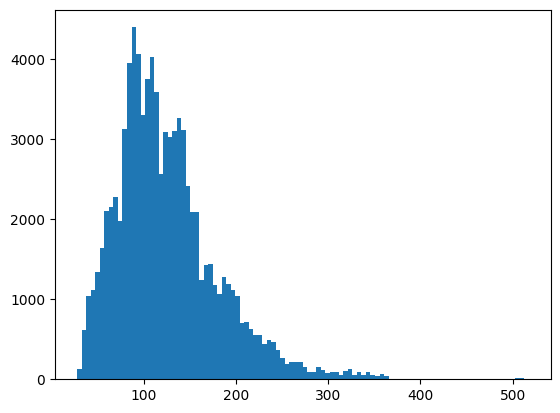

In [12]:
question_and_context = []

for item in dataset["train"]:
    question_and_context.append(item["question"] + " " + item["context"])

# Visualize the distribution of the length of the questions and contexts
import matplotlib.pyplot as plt
plt.hist([len(item.split()) for item in question_and_context], bins=100)
plt.show()

In [ ]:
def compute_metrics(eval_pred):
    f1_score = datasets.load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_score.add_batch(predictions=predictions, references=labels)
    return f1_score.compute()

from transformers import Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_data["train"],         # training dataset
    eval_dataset=tokenized_data["test"],           # evaluation dataset
    compute_metrics=compute_metrics,               # the callback that computes metrics of interest
)

trainer.train()

trainer.evaluate()